In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

In [2]:
data = pd.read_excel("C:/Users/htcso/Downloads/EVDS (3).xlsx")

In [3]:
data.head()

,Tarih,Gelir
0,2003-Q1,402.000000
1,2003-Q2,759.000000
2,2003-Q3,2360.000000
3,2003-Q4,911.666667
4,2004-Q1,578.333333


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tarih   81 non-null     object 
 1   Gelir   81 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [5]:
dates = pd.date_range(start="2003", periods=len(data["Tarih"]), freq="Q")

In [6]:
data["Tarih"] = dates
data.head()

,Tarih,Gelir
0,2003-03-31,402.000000
1,2003-06-30,759.000000
2,2003-09-30,2360.000000
3,2003-12-31,911.666667
4,2004-03-31,578.333333


In [7]:
data.dtypes

Tarih    datetime64[ns]
Gelir           float64
dtype: object

In [8]:
data = data.rename(columns = {"Gelir": "Revenue", "Tarih": "Date"}).set_index("Date")

In [9]:
data.head()

,Revenue
Date,
2003-03-31,402.000000
2003-06-30,759.000000
2003-09-30,2360.000000
2003-12-31,911.666667
2004-03-31,578.333333


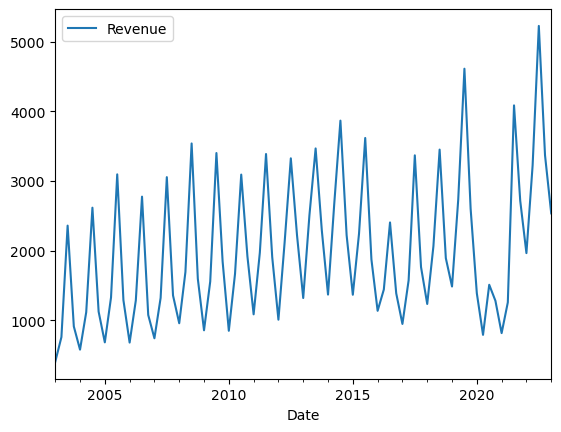

In [10]:
data.plot()
plt.show();

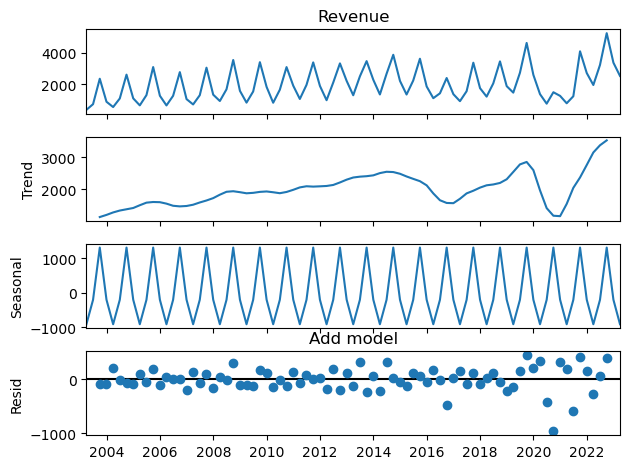

In [11]:
decomp_add = sm(data["Revenue"], model="add", period=4)
decomp_add.plot()
plt.title("Add model")
plt.show();

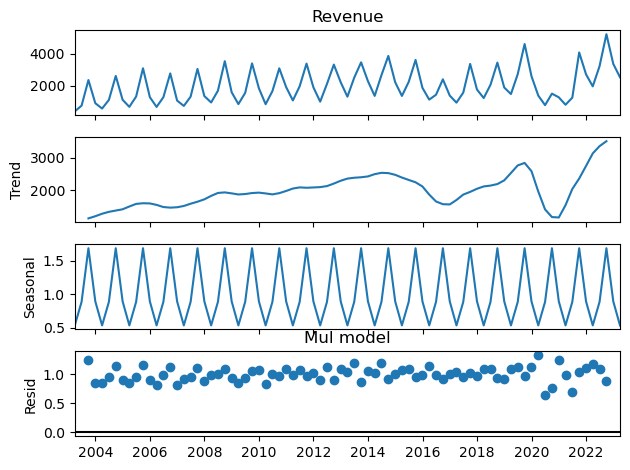

In [12]:
decomp_mul = sm(data["Revenue"], model="mul", period=4)
decomp_mul.plot()
plt.title("Mul model")
plt.show();

In [13]:
print(np.std(decomp_add.resid))
print(np.std(decomp_mul.resid))

# it seems that mul model is fitter

221.6533786887447
0.12253013610972693


In [14]:
decomp_log_add = sm(np.log(data["Revenue"]), model="add", period=4)
decomp_log_mul = sm(np.log(data["Revenue"]), model="mul", period=4)

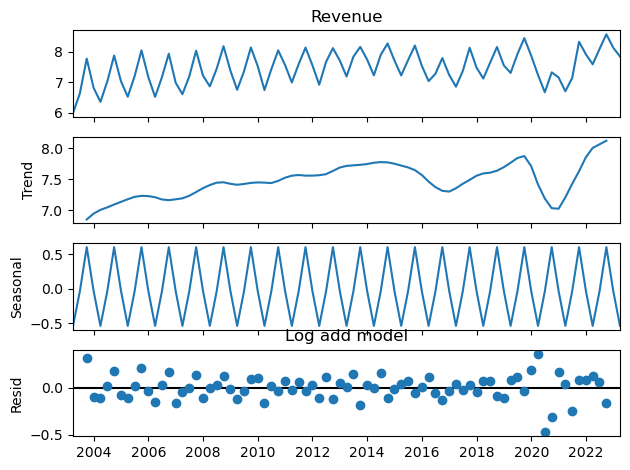

In [15]:
decomp_log_add.plot()
plt.title("Log add model")
plt.show();

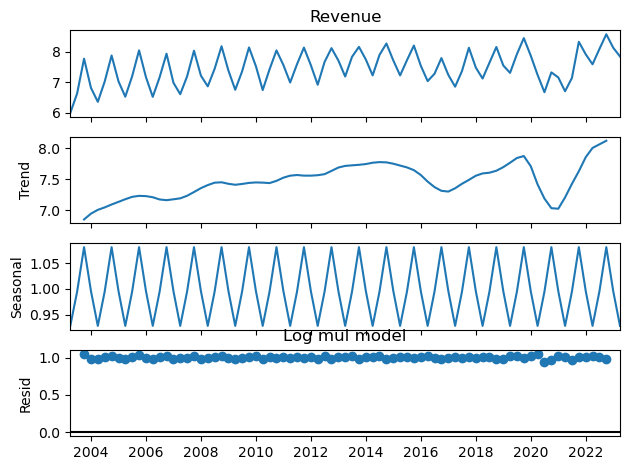

In [16]:
decomp_log_mul.plot()
plt.title("Log mul model")
plt.show();

In [17]:
decomp_mul_df = pd.concat([decomp_mul.observed,
                          decomp_mul.trend,
                          decomp_mul.seasonal,
                          decomp_mul.observed / decomp_mul.seasonal], axis=1)  # trend*resid

decomp_mul_df.columns = ["Revenue", "Trend", "Seasonality", "Seasonal Adjustment"]
decomp_mul_df.head()

,Revenue,Trend,Seasonality,Seasonal Adjustment
Date,,,,
2003-03-31,402.000000,NaN,0.535940,750.083639
2003-06-30,759.000000,NaN,0.886178,856.486817
2003-09-30,2360.000000,1130.208333,1.684527,1400.987135
2003-12-31,911.666667,1196.958333,0.893355,1020.497669
2004-03-31,578.333333,1273.875000,0.535940,1079.100426


In [18]:
index = np.arange(1, len(data.index)+1)

X = sa.add_constant(index)
model = sa.OLS(decomp_mul_df["Seasonal Adjustment"], X)
result = model.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Seasonal Adjustment   R-squared:                       0.386
Model:                             OLS   Adj. R-squared:                  0.378
Method:                  Least Squares   F-statistic:                     49.60
Date:                 Mon, 06 Nov 2023   Prob (F-statistic):           6.19e-10
Time:                         21:22:39   Log-Likelihood:                -626.98
No. Observations:                   81   AIC:                             1258.
Df Residuals:                       79   BIC:                             1263.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1250.4167    126.384      9.89

In [19]:
#it seems that data does not fit the linear model

In [20]:
# forecasting

y = pd.date_range(start = decomp_mul_df.index[-1] + pd.DateOffset(months=3),
                 periods = 4,
                 freq = "Q")

print(y)

DatetimeIndex(['2023-06-30', '2023-09-30', '2023-12-31', '2024-03-31'], dtype='datetime64[ns]', freq='Q-DEC')


In [21]:
new_row = pd.DataFrame(index = y)
decomp_mul_df = pd.concat([decomp_mul_df, new_row])

decomp_mul_df.tail()

,Revenue,Trend,Seasonality,Seasonal Adjustment
2023-03-31,2536.0,NaN,0.53594,4731.870917
2023-06-30,NaN,NaN,NaN,NaN
2023-09-30,NaN,NaN,NaN,NaN
2023-12-31,NaN,NaN,NaN,NaN
2024-03-31,NaN,NaN,NaN,NaN


In [22]:
decomp_mul_df["Seasonality"].head()

2003-03-31    0.535940
2003-06-30    0.886178
2003-09-30    1.684527
2003-12-31    0.893355
2004-03-31    0.535940
Name: Seasonality, dtype: float64

In [23]:
season = {
    3:  0.53594,
    6:  0.886178,
    9:  1.684527,
    12: 0.893355
}

decomp_mul_df["Seasonality"] = decomp_mul_df.index.month.map(season)

In [24]:
decomp_mul_df["Seasonality"].tail()

2023-03-31    0.535940
2023-06-30    0.886178
2023-09-30    1.684527
2023-12-31    0.893355
2024-03-31    0.535940
Name: Seasonality, dtype: float64

In [25]:
new_index = np.arange(1, len(data.index) + 5)
print(new_index)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]


In [26]:
reg_model = result.predict(sa.add_constant(new_index))
decomp_mul_df["Forecast"] = decomp_mul_df["Seasonality"] * reg_model
print(decomp_mul_df)

                Revenue        Trend  Seasonality  Seasonal Adjustment     Forecast
2003-03-31   402.000000          NaN     0.535940           750.083639   680.255598
2003-06-30   759.000000          NaN     0.886178           856.486817  1141.516530
2003-09-30  2360.000000  1130.208333     1.684527          1400.987135  2201.665851
2003-12-31   911.666667  1196.958333     0.893355          1020.497669  1184.456897
2004-03-31   578.333333  1273.875000     0.535940          1079.100426   720.684602
...                 ...          ...          ...                  ...          ...
2023-03-31  2536.000000          NaN     0.535940          4731.870917  1488.835673
2023-06-30          NaN          NaN     0.886178                  NaN  2478.505509
2023-09-30          NaN          NaN     1.684527                  NaN  4743.134986
2023-12-31          NaN          NaN     0.893355                  NaN  2532.273916
2024-03-31          NaN          NaN     0.535940                  NaN  1529

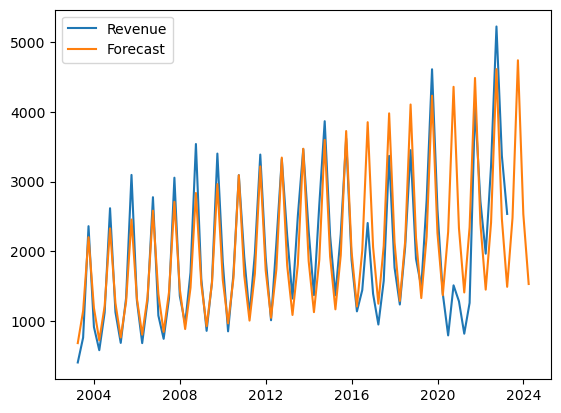

In [27]:
plt.plot(decomp_mul_df["Revenue"], label = "Revenue")
plt.plot(decomp_mul_df["Forecast"], label = "Forecast")
plt.legend()
plt.show();